In [ ]:
#Profile lines to compare the elevation using DEM with bathymetry (Blue) and without bathymetry correction (yellow).

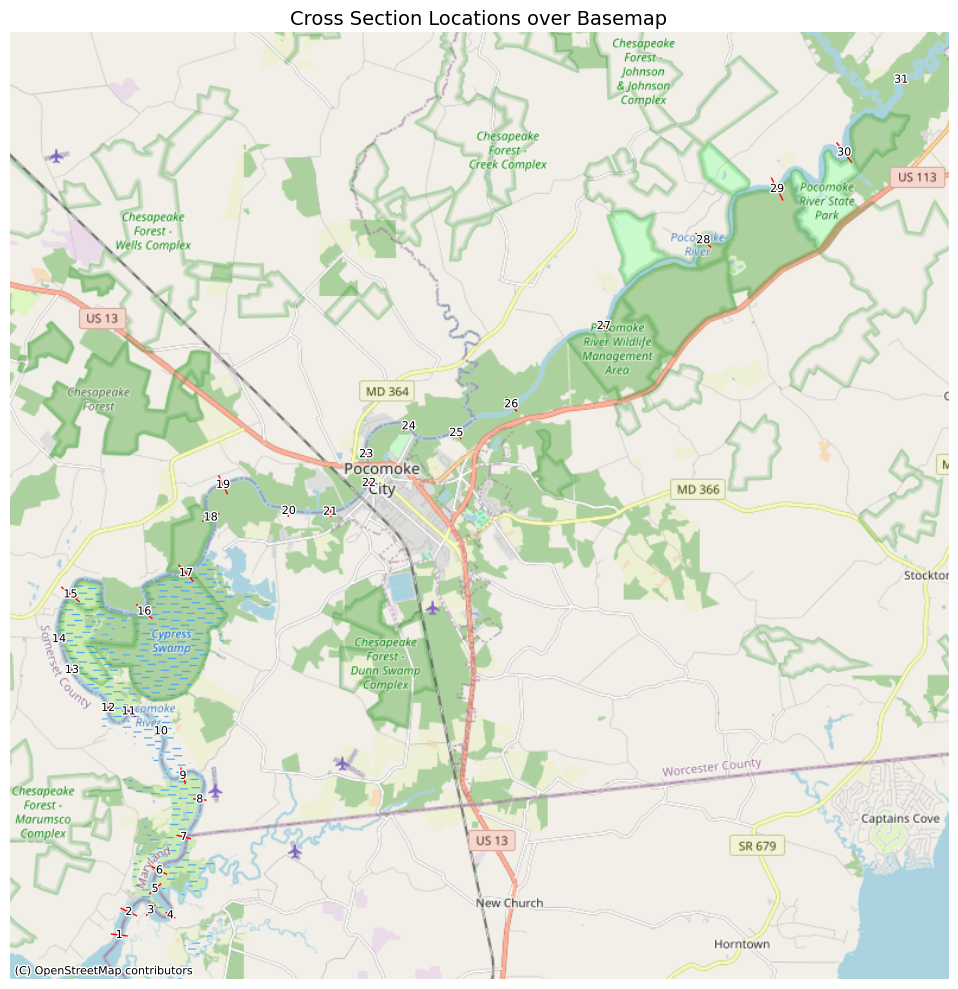

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as pe

# === Load your shapefile ===
lines_gdf = gpd.read_file(r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp")

# === Convert to Web Mercator (required for basemap tiles) ===
lines_gdf = lines_gdf.to_crs(epsg=3857)

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 10))
lines_gdf.plot(ax=ax, edgecolor='red', linewidth=1)

# Label each cross-section
for idx, row in lines_gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, str(idx + 1), fontsize=8, ha='center', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])

# Add basemap (OpenStreetMap by default)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Format
ax.set_title("Cross Section Locations over Basemap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:

import os
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import zipfile

# === INPUT PATHS ===
lines_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp"
dem_bathy_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\DEM_Bathy7.tif"
terrain_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Terrain.MD_DEMVoidFIll.tif"
output_dir = "cross_section_profiles"

# === LOAD DATA ===
lines_gdf = gpd.read_file(lines_path)
dem_bathy = rasterio.open(dem_bathy_path)
terrain_dem = rasterio.open(terrain_path)

# === FUNCTION: Sample Points Along Line ===
def interpolate_line(line, num_points=100):
    distances = np.linspace(0, line.length, num=num_points)
    return [line.interpolate(d) for d in distances]

# === CREATE OUTPUT FOLDER ===
os.makedirs(output_dir, exist_ok=True)

# === LOOP OVER EACH LINE ===
for idx, row in lines_gdf.iterrows():
    line = row.geometry
    points = interpolate_line(line, num_points=100)
    coords = [(pt.x, pt.y) for pt in points]

    # Sample elevation from both DEMs
    elev_bathy = [val[0] for val in dem_bathy.sample(coords)]
    elev_terrain = [val[0] for val in terrain_dem.sample(coords)]

    # Plot comparison
    plt.figure(figsize=(8, 4))
    plt.plot(elev_bathy, label='DEM_Bathy7', color='blue')
    plt.plot(elev_terrain, label='Terrain.MD_DEMVoidFIll', color='orange')
    plt.title(f"Cross Section {idx + 1}")
    plt.xlabel("Sample Point")
    plt.ylabel("Elevation (ft)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save figure
    plot_path = os.path.join(output_dir, f"CrossSection_{idx + 1}.png")
    plt.savefig(plot_path)
    plt.close()

print(f"✅ All profiles saved to: {output_dir}")


✅ All profiles saved to: cross_section_profiles


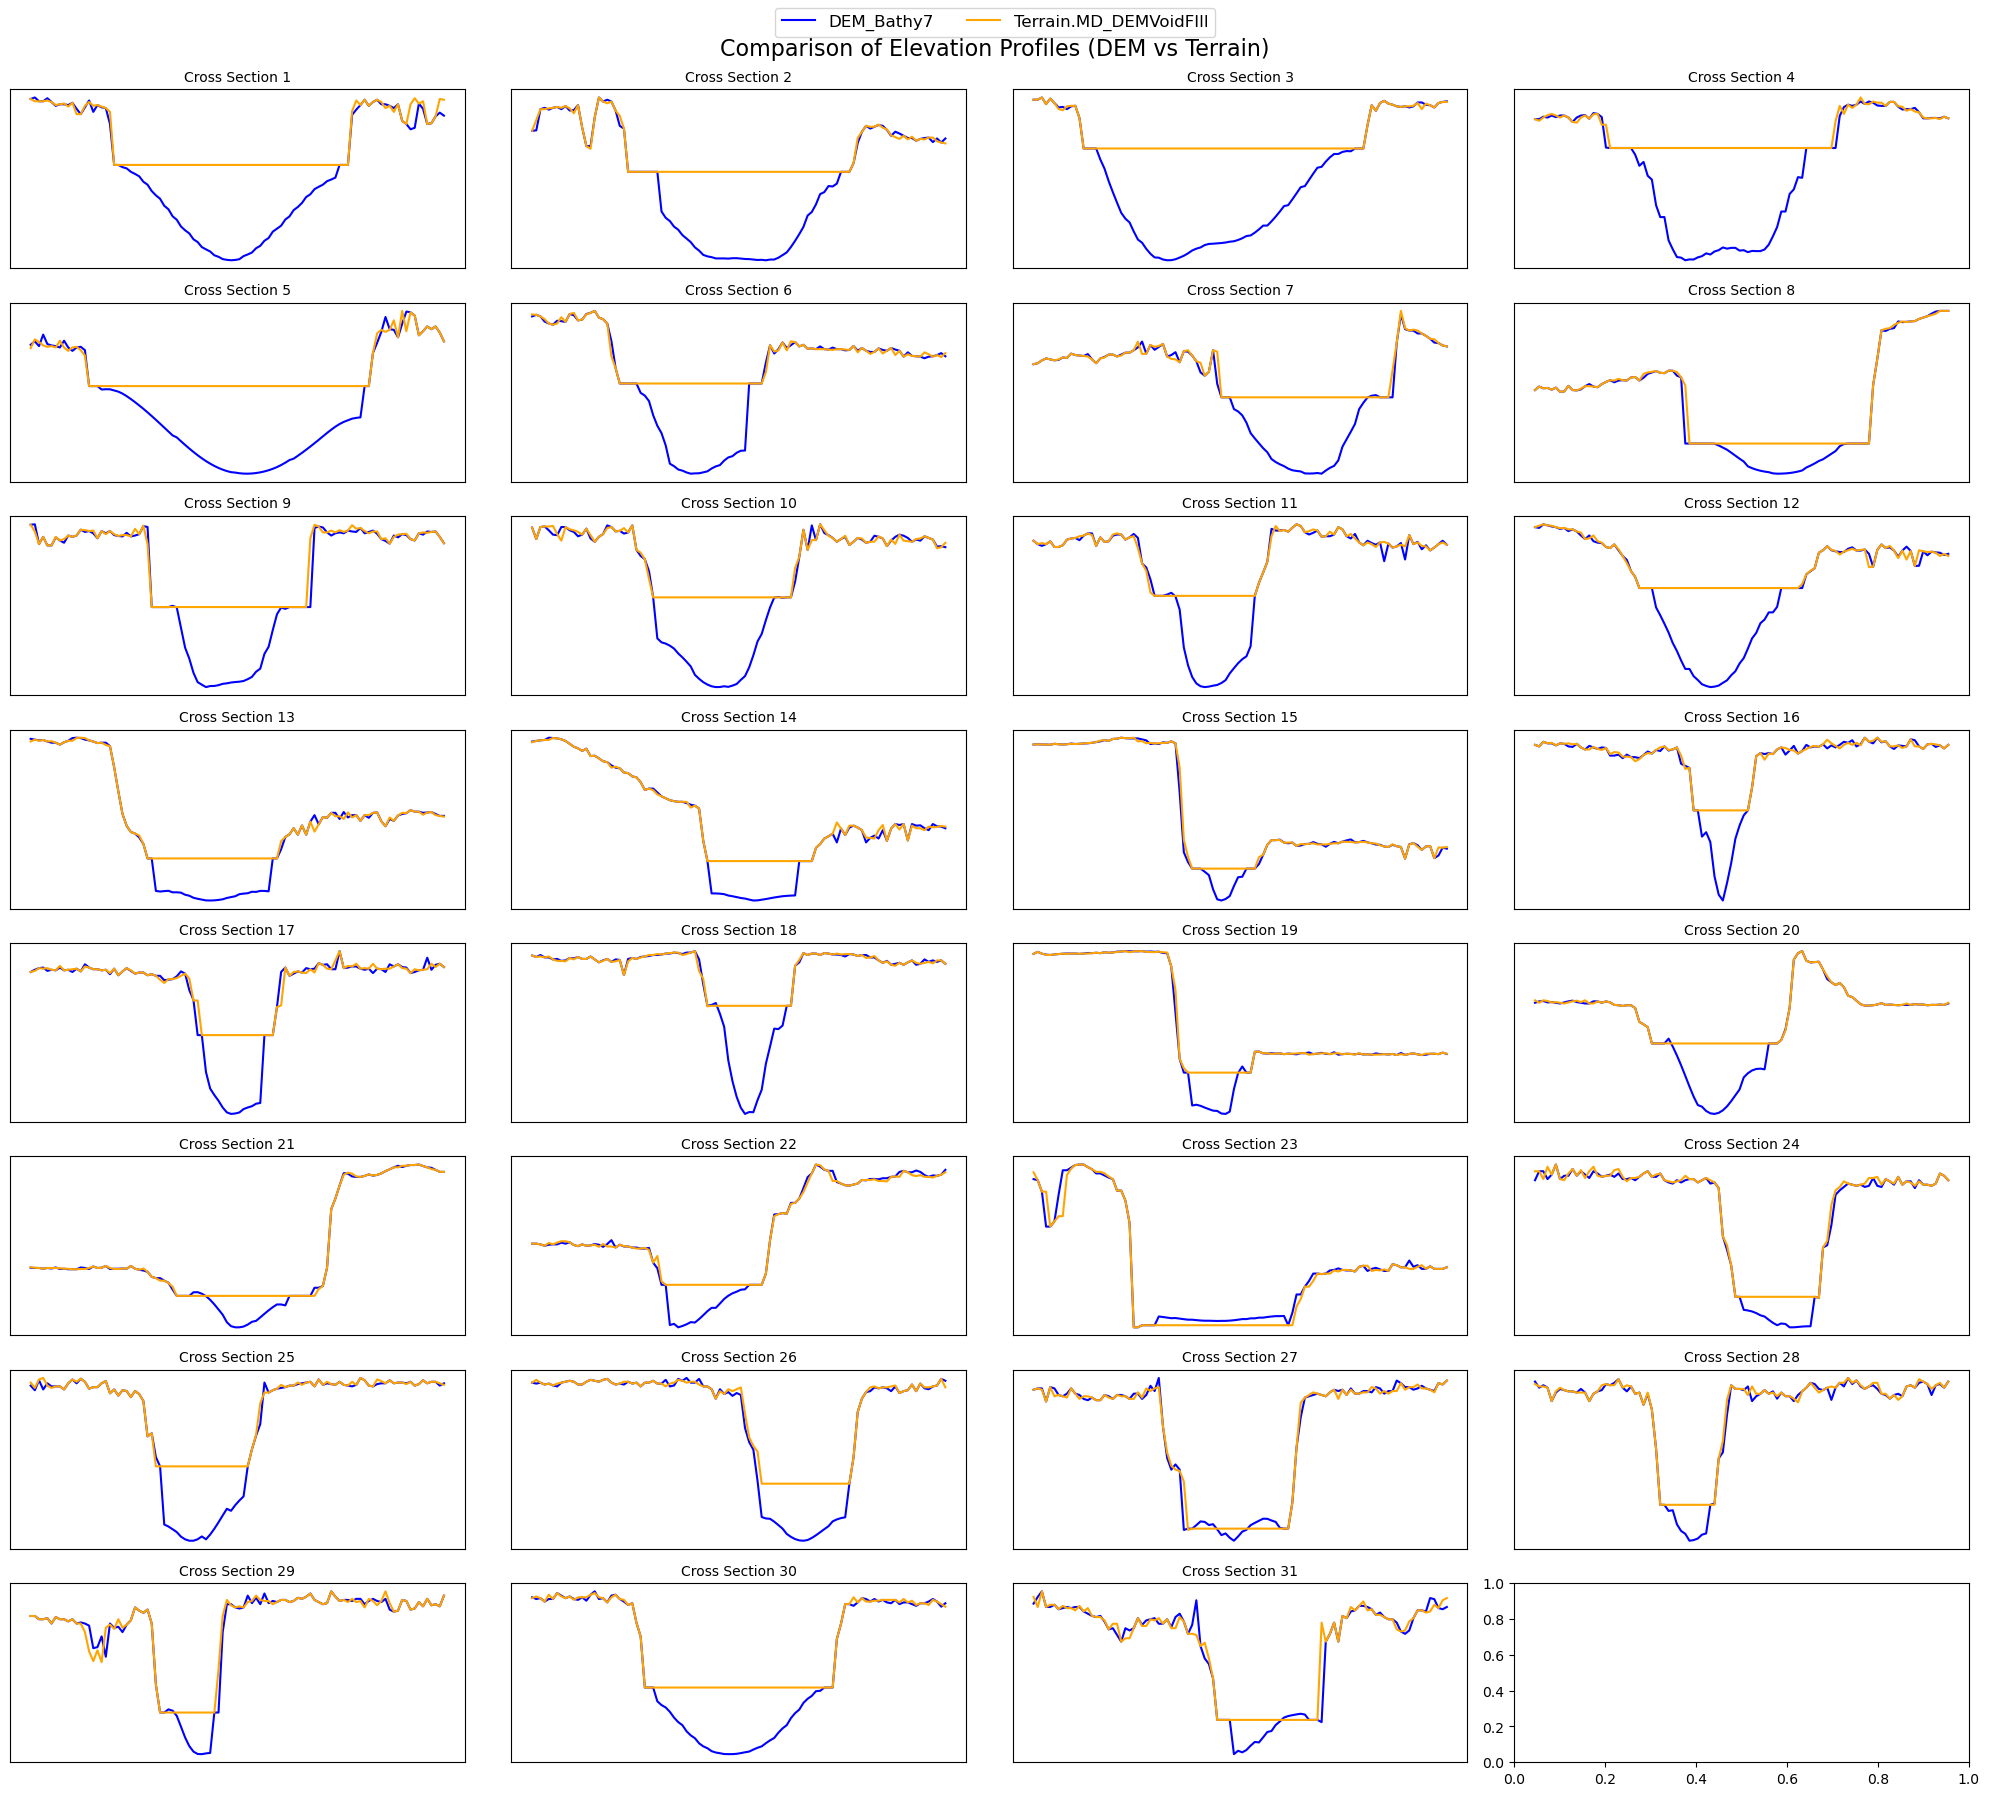

In [4]:
import os
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === INPUT PATHS ===
lines_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp"
dem_bathy_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\DEM_Bathy7.tif"
terrain_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Terrain.MD_DEMVoidFIll.tif"

# === LOAD DATA ===
lines_gdf = gpd.read_file(lines_path)
dem_bathy = rasterio.open(dem_bathy_path)
terrain_dem = rasterio.open(terrain_path)

# === FUNCTION: Sample Points Along Line ===
def interpolate_line(line, num_points=100):
    distances = np.linspace(0, line.length, num=num_points)
    return [line.interpolate(d) for d in distances]

# === SET UP GRID PLOT ===
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 18))
axes = axes.flatten()

# === LOOP OVER EACH LINE ===
for idx, row in lines_gdf.iterrows():
    if idx >= len(axes):
        break  # Just in case there are more than 32 lines

    ax = axes[idx]
    line = row.geometry
    points = interpolate_line(line, num_points=100)
    coords = [(pt.x, pt.y) for pt in points]

    # Sample elevation from both DEMs
    elev_bathy = [val[0] for val in dem_bathy.sample(coords)]
    elev_terrain = [val[0] for val in terrain_dem.sample(coords)]

    # Plot comparison
    ax.plot(elev_bathy, label='DEM_Bathy7', color='blue')
    ax.plot(elev_terrain, label='Terrain.MD_DEMVoidFIll', color='orange')
    ax.set_title(f"Cross Section {idx + 1}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True)

# === FORMAT LEGEND & LAYOUT ===
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize='large')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Comparison of Elevation Profiles (DEM vs Terrain)", fontsize=16)
plt.show()


# Plot depth for each cross section
Gauge 8571097 Shelltown, MD, Orinal datum is MLLW
Link: https://tidesandcurrents.noaa.gov/noaatidepredictions.html?id=8571097&units=standard&bdate=20240501&edate=20240514&timezone=LST/LDT&clock=24hour&datum=MLLW&interval=hilo&action=dailychart

To convert the Datum to NAVD88: + 1.17 (Link reference: https://tidesandcurrents.noaa.gov/datums.html?datum=MLLW&units=0&epoch=0&id=8571359&name=Snow+Hill&state=MD)

NOTE: I am still improving the DEM. So tomorrow I can have new plots.

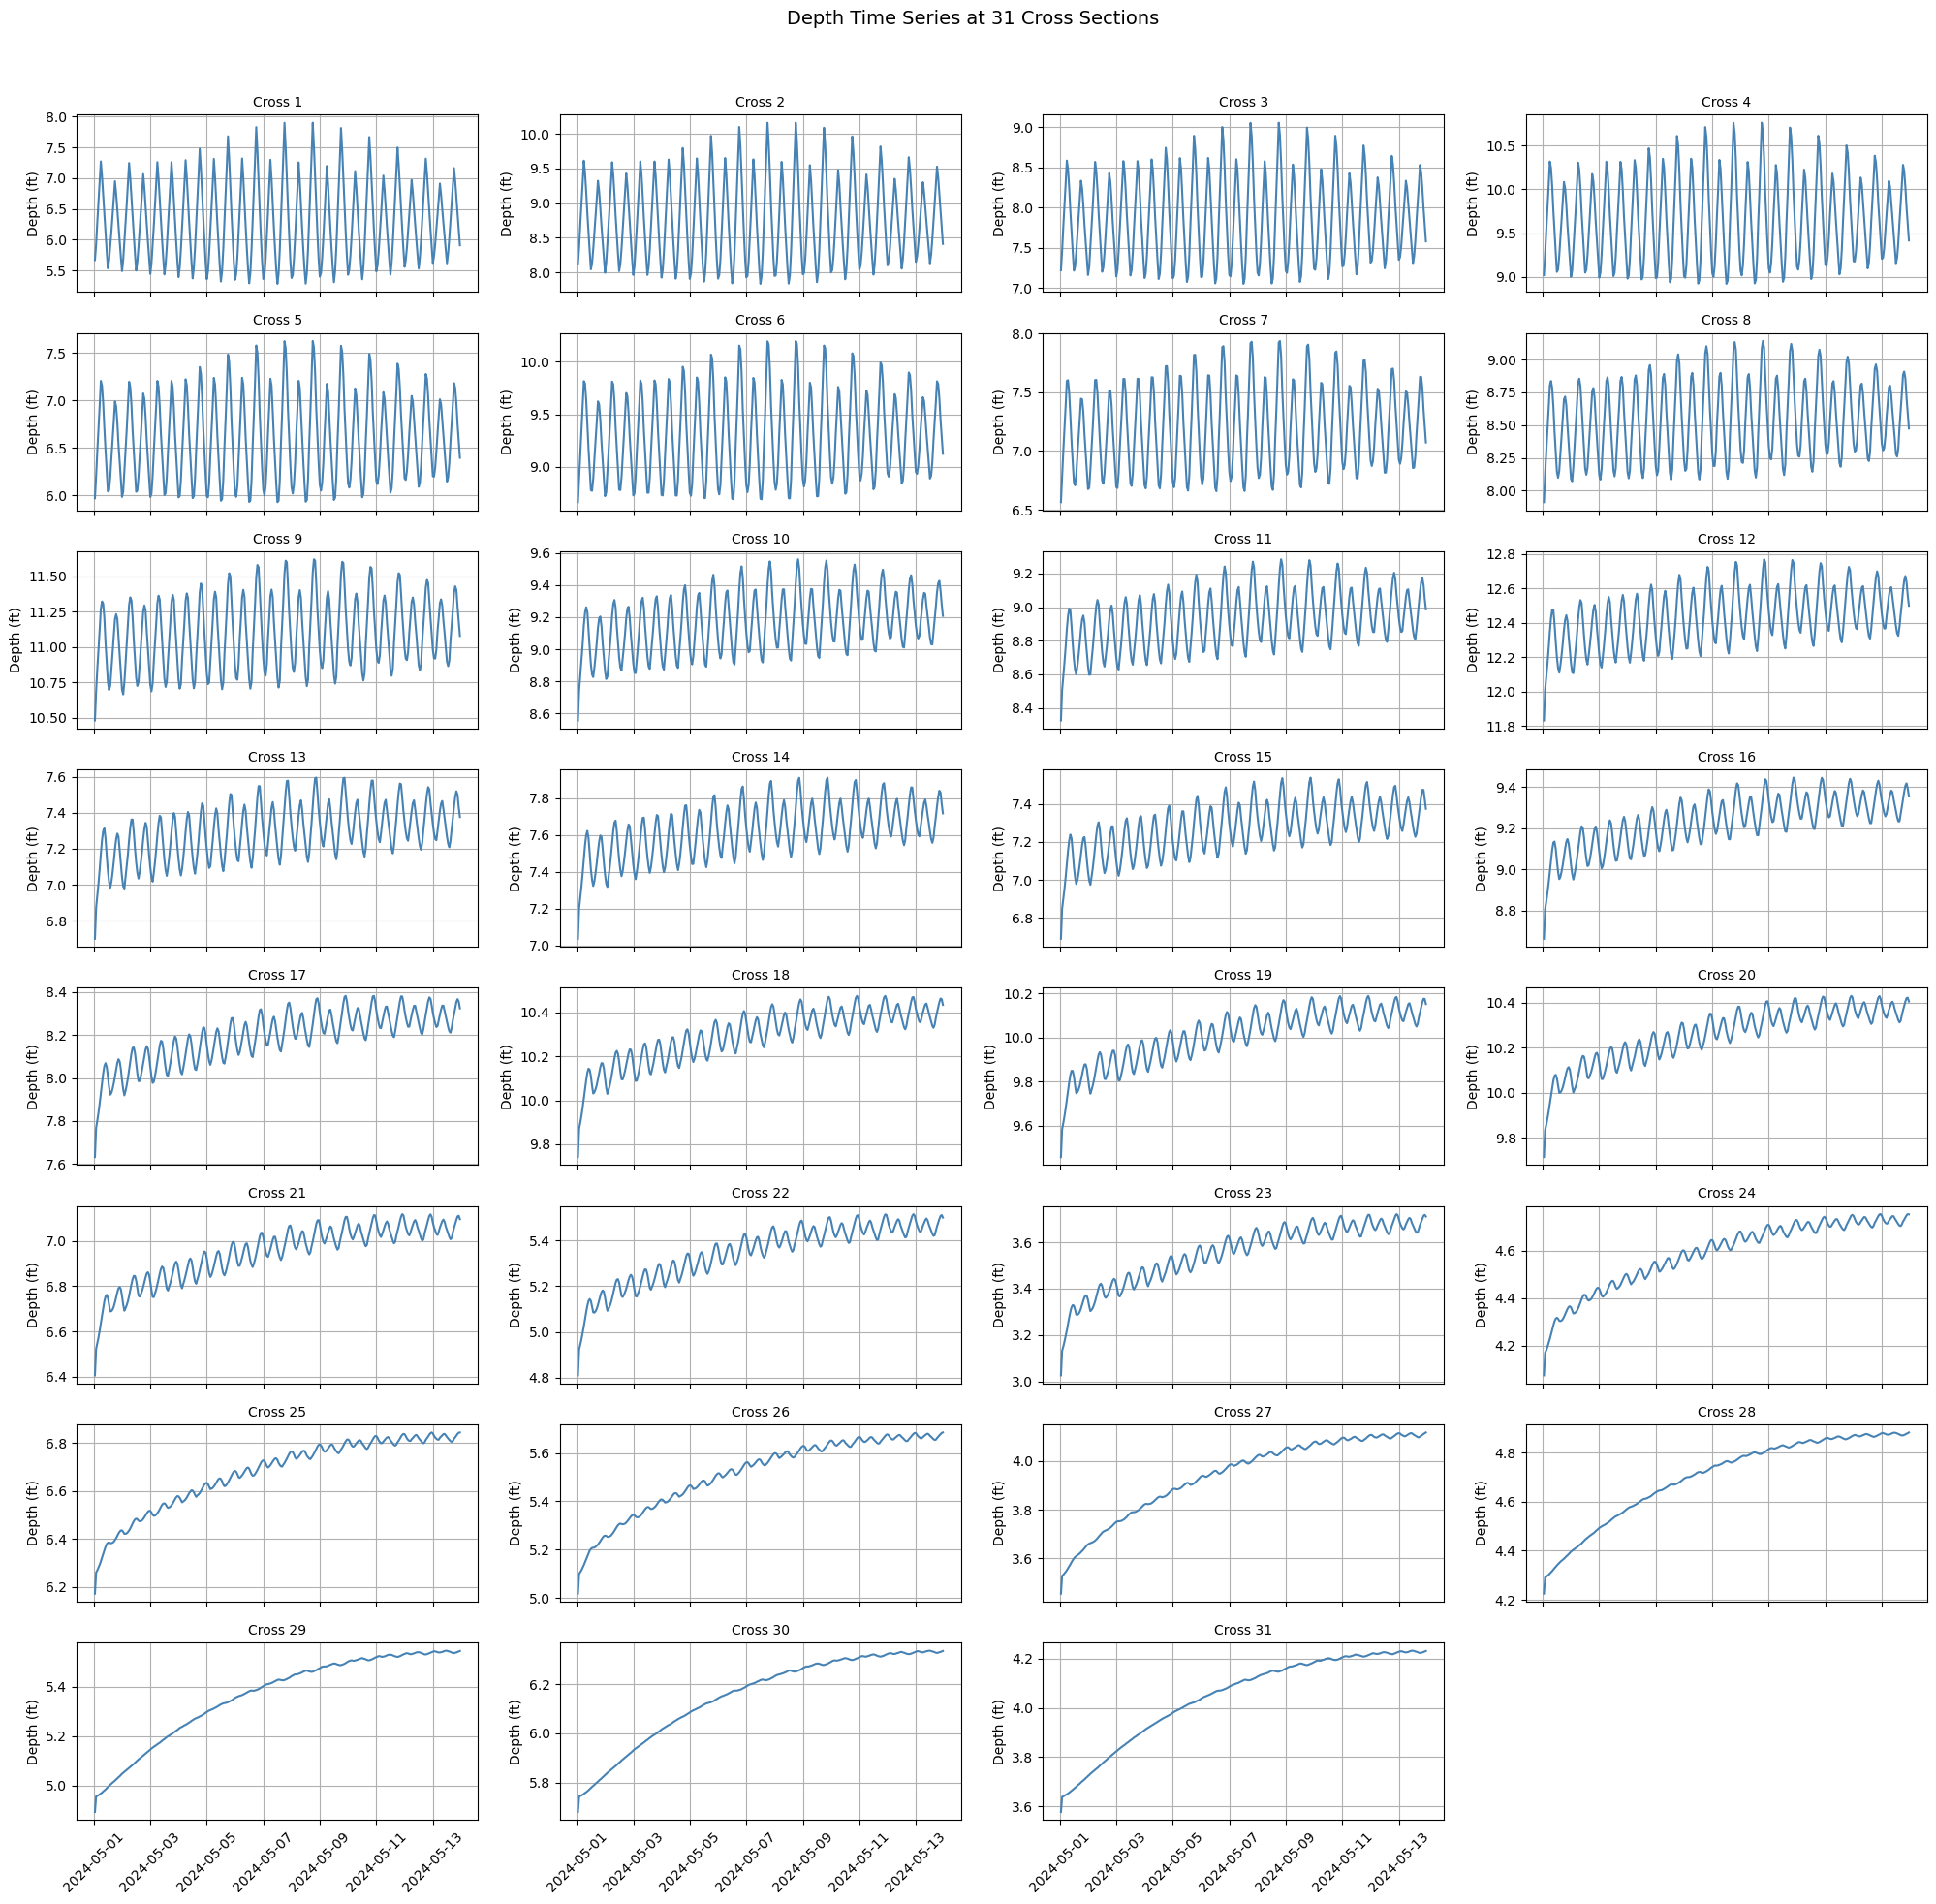

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# === File path ===
excel_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\Book2.xlsx"

# === Load Excel file, using the second row as the header
df = pd.read_excel(excel_path, header=1)

# === Convert time column to datetime
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
time = df.iloc[:, 0]

# === Settings for subplot grid
n_stations = df.shape[1] - 1
cols = 4  # Number of columns for subplots
rows = math.ceil(n_stations / cols)

# === Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 2.5), sharex=True)
axs = axs.flatten()

for i in range(n_stations):
    ax = axs[i]
    ax.plot(time, df.iloc[:, i + 1], color='steelblue')
    ax.set_title(f"Cross {i + 1}", fontsize=10)
    ax.set_ylabel("Depth (ft)")
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=45)

# === Remove unused subplots
for j in range(n_stations, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Depth Time Series at 31 Cross Sections", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
#Gauge plot

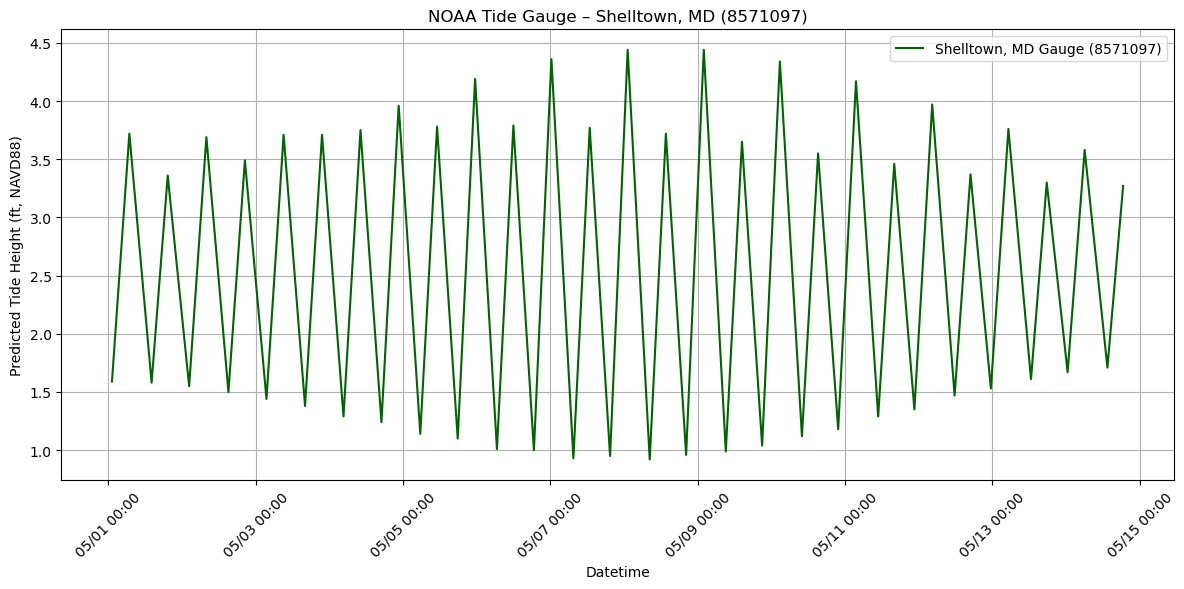

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === File path ===
excel_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\Book2.xlsx"

# === Load Sheet2
df = pd.read_excel(excel_path, sheet_name="Sheet2")

# === Clean column names and rename
df.columns = df.columns.str.strip().str.replace('\n', ' ', regex=True)
df.rename(columns={
    df.columns[0]: "Date",
    df.columns[1]: "Time",
    df.columns[2]: "Predicted"
}, inplace=True)

# === Combine Date + Time into single datetime column
df["Datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors='coerce')
df = df.dropna(subset=["Datetime"])

# === Plot with full datetime labels
plt.figure(figsize=(12, 6))
plt.plot(df["Datetime"], df["Predicted"], label="Shelltown, MD Gauge (8571097)", color='darkgreen')
plt.title("NOAA Tide Gauge – Shelltown, MD (8571097)")
plt.xlabel("Datetime")
plt.ylabel("Predicted Tide Height (ft, NAVD88)")
plt.grid(True)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()
